In [1]:
#This is not made by Hansen1015, I just edit a little bit of the code that makes it more reliable.
#the author is https://github.com/Bturan19
import os
from pathlib import Path

project_root = "./freqtrade"
i=0
try:
    os.chdirdir(project_root)
    assert Path('LICENSE').is_file()
except:
    while i<4 and (not Path('LICENSE').is_file()):
        os.chdir(Path(Path.cwd(), '../'))
        i+=1
    project_root = Path.cwd()
print(Path.cwd())

/home/develop/freqtrade


In [2]:

import json
from freqtrade.configuration import Configuration

# Load config from multiple files
config = Configuration.from_files(["config.json"])
#print(config)

# Show the config in memory
#print(json.dumps(config['original_config'], indent=2))

## Start From Here

In [3]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style()
from tqdm import tqdm

import sklearn
#import xgboost
import catboost
import scipy
import talib.abstract as ta
from scipy import signal
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### Read Files 

In [4]:
### Helper Functions

def add_features(df):
    """
    This functions takes an OHLC dataframe;
    creates functions and return dataframe
    :params: pandas.DataFrame
    
    :output: pandas.DataFrame
    """

    #sma diff
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"smadiff_{i}"] = (df['close'].rolling(i).mean() - df['close'])
    #max diff
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"maxdiff_{i}"] = (df['close'].rolling(i).max() - df['close'])
    #min diff
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"maxdiff_{i}"] = (df['close'].rolling(i).min() - df['close'])
    #volatiliy
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"std_{i}"] = df['close'].rolling(i).std()
    
    #Return
    for i in [3,5,8,13,21,34,55,89,120,240]:
        df[f"ma_{i}"] = df['close'].pct_change(i).rolling(i).mean()
    
    df['z_score_120'] = ((df.ma_13 - df.ma_13.rolling(21).mean() + 1e-9) 
                         / (df.ma_13.rolling(21).std() + 1e-9))
    
    #Target
    df[ "target"] = df['close'].shift(-7).pct_change(1).rolling(7).mean()
    
    return df
    

In [5]:
headers = ["date", "open", "high", "low", "close", "volume"]

df = []

for file in os.listdir("user_data/data/kraken/"):
    if file.endswith("1h.json"):
        filename = os.path.join("user_data/data/kraken/", file)
        print(f"Starting read: {filename}")
        d1 = pd.read_json(filename)
        d1.columns = headers
        d1["stock"] = file[:-8]
        d1 = add_features(d1)
        df.append(d1)

df = pd.concat(df)
print("Shape: ", df.shape)

Starting read: user_data/data/kraken/BAT_EUR-1h.json
Starting read: user_data/data/kraken/DOGE_EUR-1h.json
Starting read: user_data/data/kraken/BCH_EUR-1h.json
Starting read: user_data/data/kraken/AAVE_EUR-1h.json
Starting read: user_data/data/kraken/ETH_EUR-1h.json
Starting read: user_data/data/kraken/REP_EUR-1h.json
Starting read: user_data/data/kraken/ADA_EUR-1h.json
Starting read: user_data/data/kraken/LTC_EUR-1h.json
Starting read: user_data/data/kraken/MANA_EUR-1h.json
Starting read: user_data/data/kraken/SC_EUR-1h.json
Starting read: user_data/data/kraken/ANT_EUR-1h.json
Starting read: user_data/data/kraken/EWT_EUR-1h.json
Starting read: user_data/data/kraken/DOT_EUR-1h.json
Starting read: user_data/data/kraken/FLOW_EUR-1h.json
Starting read: user_data/data/kraken/EOS_EUR-1h.json
Starting read: user_data/data/kraken/XRP_EUR-1h.json
Starting read: user_data/data/kraken/CRV_EUR-1h.json
Starting read: user_data/data/kraken/OMG_EUR-1h.json
Starting read: user_data/data/kraken/ALGO_E

In [6]:
# Format date
df["date"] = pd.to_datetime(df["date"], unit='ms')
df = df.reset_index(drop=True)

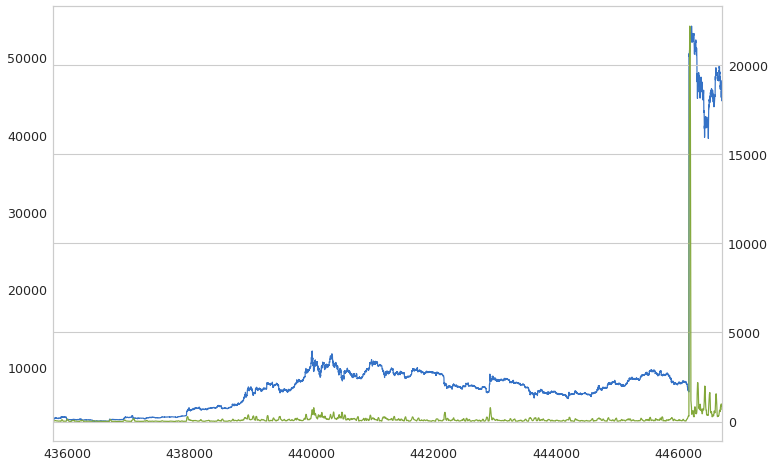

In [7]:
ax = df.loc[df.stock=='BTC_EUR', 'close'].plot(figsize=(12,8))
df.loc[df.stock=='BTC_EUR', 'close'].rolling(30).std().plot(ax=ax, secondary_y=True)

### Feature Engineering 

In [8]:
# Drop new cryptos

stock_size = df.groupby("stock").size().sort_values().reset_index()
stock_size.columns = ["stock", "size"]
uneligible_stocks = stock_size.loc[stock_size["size"] < 241].stock.to_list()

df = df.loc[~df.stock.isin(uneligible_stocks)]

In [9]:
df['time_hourmin'] = df.date.dt.hour * 60 + df.date.dt.minute
df['time_dayofweek'] = df.date.dt.dayofweek
df['time_hour'] = df.date.dt.hour

In [10]:
#df["target"] = df.target / df.meanp_tar
#HOLD

In [11]:
df = df.loc[df.date < '2021-04-10 05:00:00']
print(df.shape)

(523777, 52)


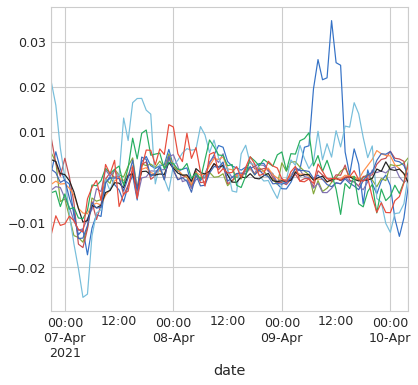

In [12]:
for st in df.stock.unique()[:10]:
    a = df.loc[df.stock==st].set_index("date")
    a.target.tail(80).plot()

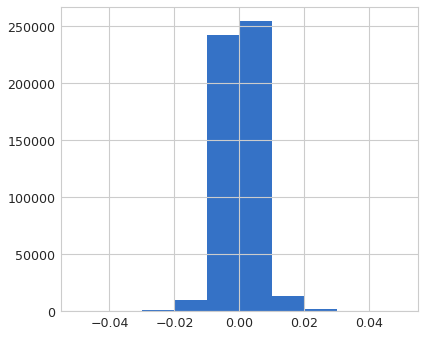

In [13]:
df.target.clip(-0.05,0.05).hist()

In [14]:
df = df.dropna()

In [15]:
df['target'] = pd.qcut(df.target, 5, labels=False)

### Train-Test Split 

In [16]:
df.date.agg(['min', 'max'])

min   2019-01-20 23:00:00
max   2021-04-10 04:00:00
Name: date, dtype: datetime64[ns]

In [17]:

config = {
    'train_split_date': pd.to_datetime('2019-04-09'),
    'val_split_date': pd.to_datetime('2020-11-01'),
    'test_split_date': pd.to_datetime('2021-03-01'),
}

train = df[(df.date >= config['train_split_date']) &
           (df.date < config['val_split_date'])]

val   = df[(df.date >= config['val_split_date']) &
           (df.date < config['test_split_date'])]

test  = df[(df.date >= config['test_split_date'])]

In [18]:
print(train.shape, train.target.mean())
print(val.shape, val.target.mean())
print(test.shape, test.target.mean())

(306424, 52) 1.960349058820458
(122380, 52) 2.0567658114070926
(46053, 52) 2.0995374894143706


In [19]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'stock', 'smadiff_3',
       'smadiff_5', 'smadiff_8', 'smadiff_13', 'smadiff_21', 'smadiff_34',
       'smadiff_55', 'smadiff_89', 'smadiff_120', 'smadiff_240', 'maxdiff_3',
       'maxdiff_5', 'maxdiff_8', 'maxdiff_13', 'maxdiff_21', 'maxdiff_34',
       'maxdiff_55', 'maxdiff_89', 'maxdiff_120', 'maxdiff_240', 'std_3',
       'std_5', 'std_8', 'std_13', 'std_21', 'std_34', 'std_55', 'std_89',
       'std_120', 'std_240', 'ma_3', 'ma_5', 'ma_8', 'ma_13', 'ma_21', 'ma_34',
       'ma_55', 'ma_89', 'ma_120', 'ma_240', 'z_score_120', 'target',
       'time_hourmin', 'time_dayofweek', 'time_hour'],
      dtype='object')

In [20]:
col_not_use = ["date", 'open', 'high', 'low', 'close',
               "target","meanp_tar", 
               "logclose", "sqrtclose", "stock"
              ]
col_use = [c for c in df.columns if c not in col_not_use]

In [21]:
from catboost import CatBoostClassifier

In [22]:
model_return = CatBoostClassifier(iterations=12000,
                          #boosting_type='dart',
                          #random_state=42,
                          #num_leaves=41,
                          learning_rate=0.002,
                          #max_bin =10,
                          task_type='GPU')
model_return.fit(train[col_use], train['target'],
             #eval_metric='binary_error',
             verbose=100,
             #early_stopping_rounds=200,
             eval_set=[(val[col_use], val['target'])],
                )

0:	learn: 1.6092540	test: 1.6092801	best: 1.6092801 (0)	total: 13.1ms	remaining: 2m 36s
100:	learn: 1.5923846	test: 1.5941055	best: 1.5941055 (100)	total: 1.12s	remaining: 2m 12s
200:	learn: 1.5793755	test: 1.5821924	best: 1.5821924 (200)	total: 2.03s	remaining: 1m 59s
300:	learn: 1.5689524	test: 1.5725694	best: 1.5725694 (300)	total: 2.95s	remaining: 1m 54s
400:	learn: 1.5604433	test: 1.5645372	best: 1.5645372 (400)	total: 3.94s	remaining: 1m 53s
500:	learn: 1.5533565	test: 1.5577932	best: 1.5577932 (500)	total: 4.91s	remaining: 1m 52s
600:	learn: 1.5473747	test: 1.5520804	best: 1.5520804 (600)	total: 5.9s	remaining: 1m 51s
700:	learn: 1.5422586	test: 1.5474080	best: 1.5474080 (700)	total: 6.93s	remaining: 1m 51s
800:	learn: 1.5378088	test: 1.5433994	best: 1.5433994 (800)	total: 7.96s	remaining: 1m 51s
900:	learn: 1.5338506	test: 1.5399487	best: 1.5399487 (900)	total: 9.13s	remaining: 1m 52s
1000:	learn: 1.5303212	test: 1.5368963	best: 1.5368963 (1000)	total: 10.3s	remaining: 1m 53s
1

8900:	learn: 1.4536955	test: 1.5090218	best: 1.5087154 (7336)	total: 1m 29s	remaining: 31.1s
9000:	learn: 1.4532160	test: 1.5090330	best: 1.5087154 (7336)	total: 1m 30s	remaining: 30.1s
9100:	learn: 1.4527255	test: 1.5090492	best: 1.5087154 (7336)	total: 1m 31s	remaining: 29s
9200:	learn: 1.4522498	test: 1.5090747	best: 1.5087154 (7336)	total: 1m 32s	remaining: 28s
9300:	learn: 1.4517624	test: 1.5090970	best: 1.5087154 (7336)	total: 1m 33s	remaining: 27s
9400:	learn: 1.4512925	test: 1.5091193	best: 1.5087154 (7336)	total: 1m 33s	remaining: 26s
9500:	learn: 1.4508119	test: 1.5091410	best: 1.5087154 (7336)	total: 1m 34s	remaining: 25s
9600:	learn: 1.4503262	test: 1.5092003	best: 1.5087154 (7336)	total: 1m 35s	remaining: 23.9s
9700:	learn: 1.4499027	test: 1.5092274	best: 1.5087154 (7336)	total: 1m 36s	remaining: 22.9s
9800:	learn: 1.4494344	test: 1.5092642	best: 1.5087154 (7336)	total: 1m 37s	remaining: 21.9s
9900:	learn: 1.4489652	test: 1.5092983	best: 1.5087154 (7336)	total: 1m 38s	rema

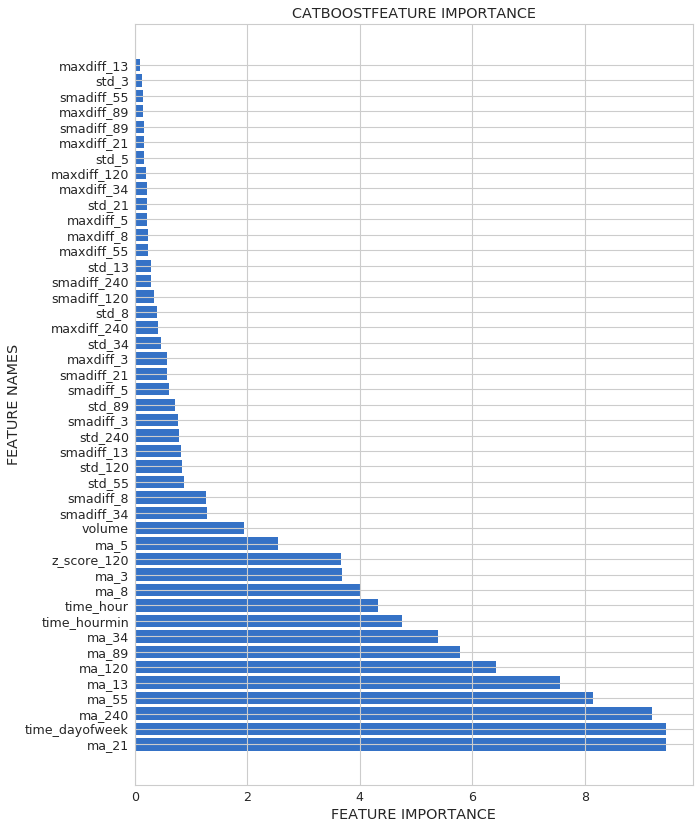

In [23]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,14))
    #Plot Searborn bar chart
    plt.barh(width=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(model_return.get_feature_importance(),col_use,'CATBOOST')

In [24]:
preds = pd.DataFrame(model_return.predict_proba(test[col_use]))
from sklearn.metrics import log_loss
print(log_loss(test.target, preds))
preds.columns = [f"pred{i}" for i in range(5)]
preds

1.5494782162621679


,pred0,pred1,pred2,pred3,pred4
0,0.271928,0.231249,0.126956,0.198113,0.171754
1,0.273822,0.226772,0.126946,0.189053,0.183406
2,0.282766,0.215741,0.119516,0.187581,0.194396
3,0.271261,0.206667,0.119816,0.186340,0.215915
4,0.264619,0.203813,0.120822,0.184788,0.225958
...,...,...,...,...,...
46048,0.154727,0.211782,0.172454,0.234221,0.226816
46049,0.234646,0.258247,0.149027,0.167726,0.190354
46050,0.240927,0.272128,0.154496,0.159909,0.172541
46051,0.212011,0.229771,0.167278,0.187942,0.202998


In [25]:
import pickle

with open('user_data/notebooks/model_portfolio.pkl', 'wb') as f:
    pickle.dump([model_return], f)

In [26]:
test = test.reset_index(drop=True)
test = pd.concat([test, preds], axis=1)

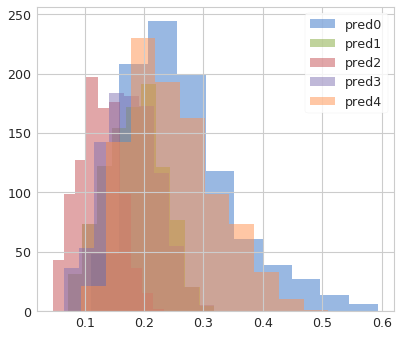

In [27]:
for i in range(5):
    test.groupby("date").tail(1)[f"pred{i}"].hist(alpha=.5, label=f"pred{i}")
plt.legend()

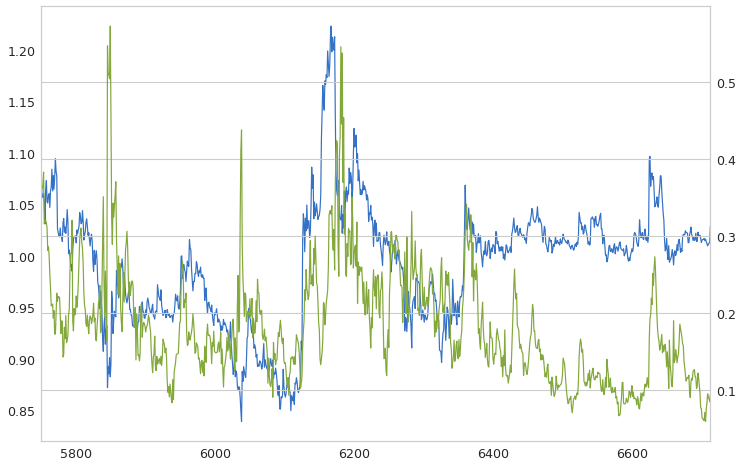

In [28]:
ax = test.loc[test.stock == 'ADA_EUR', 'close'].plot(figsize=(12,8))
test.loc[test.stock == 'ADA_EUR', 'pred4'].plot(ax=ax, secondary_y=True)

In [29]:
test.loc[test.pred4 > .25].stock.unique()

array(['BAT_EUR', 'DOGE_EUR', 'BCH_EUR', 'AAVE_EUR', 'ETH_EUR', 'REP_EUR',
       'ADA_EUR', 'LTC_EUR', 'MANA_EUR', 'SC_EUR', 'ANT_EUR', 'EWT_EUR',
       'DOT_EUR', 'FLOW_EUR', 'EOS_EUR', 'XRP_EUR', 'CRV_EUR', 'OMG_EUR',
       'ALGO_EUR', 'QTUM_EUR', 'DASH_EUR', 'ZEC_EUR', 'XTZ_EUR',
       'UNI_EUR', 'XLM_EUR', 'COMP_EUR', 'FIL_EUR', 'LINK_EUR',
       'KAVA_EUR', 'STORJ_EUR', 'LSK_EUR', 'OXT_EUR', 'TRX_EUR',
       'GRT_EUR', 'XMR_EUR', 'YFI_EUR', 'MLN_EUR', 'KEEP_EUR', 'ICX_EUR',
       'ETC_EUR', 'ATOM_EUR', 'NANO_EUR', 'KSM_EUR', 'WAVES_EUR',
       'BAL_EUR', 'OCEAN_EUR', 'KNC_EUR'], dtype=object)

In [30]:
test.date.min()

Timestamp('2021-03-01 00:00:00')

In [31]:
test.loc[test.date == '2021-03-01 00:00:00'].sort_values(by=['pred4'], ascending=False)

,date,open,high,low,close,volume,stock,smadiff_3,smadiff_5,smadiff_8,smadiff_13,smadiff_21,smadiff_34,smadiff_55,smadiff_89,smadiff_120,smadiff_240,maxdiff_3,maxdiff_5,maxdiff_8,maxdiff_13,maxdiff_21,maxdiff_34,maxdiff_55,maxdiff_89,maxdiff_120,maxdiff_240,std_3,std_5,std_8,std_13,std_21,std_34,std_55,std_89,std_120,std_240,ma_3,ma_5,ma_8,ma_13,ma_21,ma_34,ma_55,ma_89,ma_120,ma_240,z_score_120,target,time_hourmin,time_dayofweek,time_hour,pred0,pred1,pred2,pred3,pred4
9609,2021-03-01,3.179300,3.225500,3.151700,3.225500,5.436412e+02,ANT_EUR,-0.049433,-0.035100,-0.055400,-0.080538,-0.041124,0.068782,0.134709,0.227361,0.319037,0.855984,-0.085800,-0.085800,-0.163400,-0.213800,-0.213800,-0.213800,-0.213800,-0.213800,-0.213800,-0.213800,0.044367,0.037030,0.053498,0.066419,0.076467,0.166283,0.158998,0.198805,0.234324,0.671140,-0.009260,0.029460,0.001082,-0.047323,-0.082110,-0.048417,-0.086387,-0.155748,-0.226416,-0.188683,0.297971,4,0,0,0,0.291917,0.081396,0.055318,0.122616,0.448753
14849,2021-03-01,1.467000,1.504000,1.460000,1.500000,8.437238e+03,CRV_EUR,-0.026667,-0.026000,-0.049750,-0.062846,-0.055286,0.021265,0.072273,0.119596,0.171683,0.434721,-0.042000,-0.042000,-0.126000,-0.126000,-0.126000,-0.126000,-0.126000,-0.126000,-0.126000,-0.126000,0.023180,0.018815,0.040471,0.038429,0.032656,0.111674,0.111466,0.120915,0.140466,0.341114,0.005687,0.048853,0.011256,-0.040615,-0.121830,-0.070858,-0.092013,-0.161856,-0.232396,-0.234916,1.219754,1,0,0,0,0.308908,0.087129,0.058783,0.122708,0.422471
36030,2021-03-01,28.586000,28.631000,28.435000,28.435000,8.835283e+00,MLN_EUR,0.183667,0.114000,0.111875,0.601615,0.980857,1.400824,1.913545,2.545303,2.973675,6.169637,0.000000,-0.046000,-0.457000,-0.457000,-0.457000,-0.457000,-0.457000,-0.457000,-0.457000,-0.457000,0.184001,0.166038,0.316910,0.717087,0.780801,0.836508,0.953209,1.251050,1.491699,4.173598,0.011726,-0.014062,-0.045177,-0.035912,-0.045962,-0.040283,-0.064353,-0.090821,-0.164265,-0.155216,-2.035642,4,0,0,0,0.237341,0.106627,0.078383,0.164522,0.413127
37927,2021-03-01,1.158700,1.195200,1.152700,1.189000,5.390727e+03,ICX_EUR,-0.025300,-0.020140,-0.037038,-0.045085,-0.026200,0.017412,0.042076,0.077518,0.109028,0.267998,-0.039000,-0.039000,-0.093100,-0.093100,-0.093100,-0.093100,-0.093100,-0.093100,-0.093100,-0.127700,0.021936,0.018004,0.031703,0.028936,0.034842,0.066655,0.064104,0.084450,0.099111,0.249298,-0.005565,0.045461,-0.002831,-0.055895,-0.091408,-0.046043,-0.092278,-0.082855,-0.182148,0.317120,0.202466,4,0,0,0,0.328125,0.121361,0.067419,0.133461,0.349634
5749,2021-03-01,1.090094,1.096403,1.053330,1.055318,1.533936e+06,ADA_EUR,0.016670,0.026808,0.005267,-0.009389,-0.015559,0.010519,0.021266,-0.046536,-0.087827,-0.149156,0.000000,0.000000,-0.061230,-0.061230,-0.070554,-0.078068,-0.078068,-0.226083,-0.240521,-0.346467,0.016513,0.022272,0.038797,0.037024,0.038983,0.058980,0.063528,0.103506,0.113748,0.111828,-0.011882,0.065020,0.019500,0.008973,-0.075912,0.055319,0.222324,0.206281,0.152112,0.270226,1.631362,3,0,0,0,0.293183,0.139349,0.080614,0.142065,0.344789
12919,2021-03-01,2.880000,2.928600,2.867000,2.914600,9.433248e+03,EOS_EUR,-0.020700,-0.019020,-0.054387,-0.071569,-0.060371,0.026976,0.064236,0.104960,0.163615,0.605126,-0.037300,-0.037300,-0.170600,-0.170600,-0.170600,-0.170600,-0.170600,-0.170600,-0.170600,-0.170600,0.018985,0.014352,0.060807,0.059543,0.051267,0.127868,0.117549,0.133007,0.154959,0.545487,0.001624,0.039899,0.005160,-0.027902,-0.072764,-0.024067,-0.049966,-0.136032,-0.215880,-0.060638,0.915322,1,0,0,0,0.277129,0.130036,0.086094,0.175350,0.331391
45089,2021-03-01,1.300000,1.326400,1.293700,1.326400,7.130588e+03,KNC_EUR,-0.019333,-0.016000,-0.039450,-0.051523,-0.047662,0.002950,0.021022,0.029357,0.034162,0.188873,-0.033000,-0.033000,-0.104900,-0.104900,-0.104900,-0.104900,-0.104900,-0.104900,-0.104900,-0.126400,0.017214,0.014799,0.038086,0.035340,0.029636,0.075502,0.069433,0.073189,0.065294,0.212698,0.002152,0.054774,0.011696,-0.029773,-0.090315,-0.013980,-0.014492,

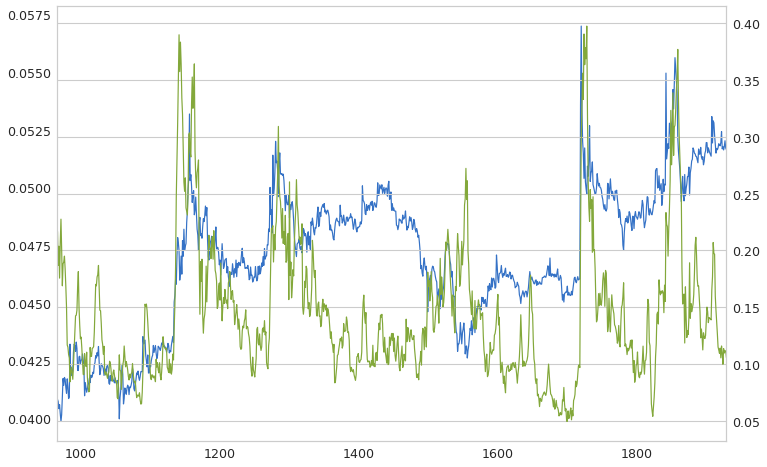

In [32]:
ax = test.loc[test.stock == 'DOGE_EUR', 'close'].plot(figsize=(12,8))
test.loc[test.stock == 'DOGE_EUR', 'pred4'].plot(ax=ax, secondary_y=True)

In [33]:
# SELECT FIRST N ASSET

test["buy"] = 0
for time in test.date.unique():
    stocks = test.loc[test.date == time].sort_values(by=['pred4'], 
                                                     ascending=False)["stock"][:10]
    test.loc[(test.date == time) &
             (test.stock.isin(stocks)), "buy"] = 1

In [34]:
test["buy"] = test["buy"].shift(1)

In [35]:
test["return"] = 1 + (test.close.shift(-1).pct_change())

## Re-Diversified Portfolio in Every 3 Hour

In [36]:
test["return"] = 1 + (test.close.shift(-1).pct_change())

test["return"] = (test["return"] * 
                  test["return"].shift(-1) * 
                  test["return"].shift(-2) *
                  test["return"].shift(-3) * 
                  test["return"].shift(-4)
                 ) 

In [37]:
test["return"].fillna(1.0, inplace=True)

In [38]:
amount = [10000]
benchmark = [10000]

for i, time in enumerate(sorted(test.date.unique())[:-5]):
    if i % 3== 0:
        returns = test.loc[(test.date == time) & (test.buy ==1), "return"].iloc[:10].mean()
        returns -= returns * 0.001
        if np.isnan(returns):
            returns = 1.
        if returns >= 1.5:
            returns = 1.5
        print(len(test.loc[(test.date == time) & (test.buy ==1), "return"]))
        amount.append((amount[-1] * returns) - amount[-1]*0.001)
        benchmark.append((benchmark[-1] * test.loc[(test.date == time), "return"].mean()))
    else:
        continue

9
9
11
10
10
10
10
10
10
11
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
9
10
10
10
10
10
10
10
10
10
10
10
11
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


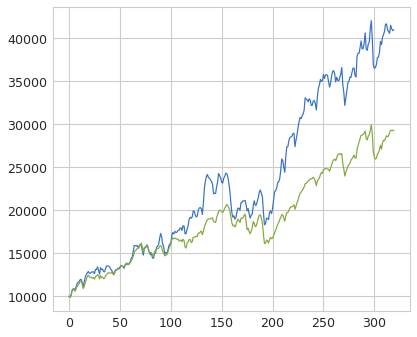

In [39]:
plt.plot(amount[:-1])
plt.plot(benchmark[:-1])

In [40]:
# Weighted portfolio

amount = [10000]
benchmark = [10000]

for i, time in enumerate(sorted(test.date.unique())[:-5]):
    if i % 3== 0:
        returns = test.loc[(test.date == time) & (test.buy ==1)].sort_values(by='pred4')["return"]
        weights = np.array([.3, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
        returns = (returns * weights).sum() / weights.sum()
        #returns -= returns * 0.001
        if returns >= 1.5:
            returns = 1.5
        amount.append((amount[-1] * returns) - amount[-1]*0.001)
        benchmark.append((benchmark[-1] * test.loc[(test.date == time), "return"].mean()))
    else:
        continue

ValueError: operands could not be broadcast together with shapes (9,) (10,) 

In [ ]:
plt.plot(amount[:-1])
plt.plot(benchmark[:-1])

In [ ]:
# Approach 2
r = pd.Series(amount).diff()

sr = r.mean()/r.std() * np.sqrt(252 * 24 /3)
print(sr)

In [ ]:
result = pd.DataFrame()
result["returns"] = pd.Series(amount)

In [ ]:
result['rolling_SR'] = result.returns.rolling(8*7).apply(lambda x: 
                                                         (x.mean() - 0.02) / x.std(), 
                                                         raw = True)
result.fillna(0, inplace = True)
result[result['rolling_SR'] > 0].rolling_SR.plot(style='-', lw=3, color='orange', 
                                         label='Sharpe', figsize = (10,7))\
                                         .axhline(y = 4., color = "blue", lw = 3,
                                                 linestyle = '--')

plt.ylabel('Sharpe ratio')
plt.legend(loc='best')
plt.title('Rolling Sharpe ratio (1 week)')
plt.show()

print('---------------------------------------------------------------')
print('In case you want to check the result data\n')
print(result.tail()) # I use tail, beacause of the size of your window.